In [1]:
#%matplotlib inline
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/MEPS/')
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import createFolder as cF
import calc_date as cd
import plot_sfc_spaghetti_ret as spagh
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import calc_48h_acc as acc
import fill_values as fv
import plot_vertical as pvert
from matplotlib.gridspec import GridSpec

import os

import pandas as pd
import matplotlib as mpl
mpl.style.use('ggplot')

In [2]:
year = 2016
month = 12
tid = '00'
#tid = '18'
station = 'Haukeliseter'
savefig = 0  # 1 = yes, 0 = no

### if plot with double fence data
dofe = 1     # 1 = yes, 0 = no

In [3]:
#### days 
#t = ['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
#t = ['22']

In [4]:
champ = 255.
no1 = np.array([79,94,26])/champ
no2 = np.array([131,156,45])/champ
no3 = np.array([71,153,112])/champ
no4 = np.array([77,111,157])/champ
no5 = np.array([157,58,55])/champ
no6 = np.array([211,120,50])/champ
no7 = np.array([218,181,70])/champ

colors = [no1, no2, no3, no4, no5, no6, no7]

In [5]:
var_name = 'precipitation_amount_acc'
unit = '[mm]'
figdir = '../../Figures/Retrieval_MEPS/%s/ensemble_mean' %(var_name)
#figdir = '../../Figures/Retrieval/%s' %(var_name)
figdir_scatter = '../../Figures/Retrieval/%s/scatter' %var_name
# Folder where the figures are being saved    
cF.createFolder('%s/' %(figdir))
cF.createFolder('%s/' %(figdir_scatter))
form = 'png'

In [6]:
################################################################
### Haukeli obs.
txtdir = '../../Data/eklima/'
txt_filename = 'Observations-hour_minutes'

################################################################
### Retrieval 
nc_dir_retrieval = '../../Data/Retrieved_SWC'

################################################################



In [7]:
# read in the Haukeliseter observation file, sorted by daily values
Haukeli = pd.read_csv('%s/%s.txt' %(txtdir, txt_filename),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')

DateHour = Haukeli['Date-Hour(UTC)']

RR_1 = Haukeli['RR_1'].astype(float)           # Precipitation (1 hour); [mm]
DD   = Haukeli['DD'].astype(float)             # Wind direction (FF); [degrees]
FF   = Haukeli['FF'].astype(float)             # Wind speed (10 meters above ground);m/s

if tid == '18':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values_18UTC(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily_18UTC(RR_1, DateHour)
if tid == '00':
    precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values(RR_1, DateHour)
    dt, p, hour, dy, mm, yr = obsDat.arange_daily(RR_1, DateHour)

   

In [8]:
idxFF = np.where(FF[:] == -9999)
idxDD = np.where(DD[:] == -9999)

FF[idxFF[0][:]] = np.nan
DD[idxDD[0][:]] = np.nan

### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - DD
for k in range(0,md_deg.shape[0]):
    if md_deg[k] <0 :
        md_deg[k] = md_deg[k] +360
md_rad = math.pi/180. * md_deg
uwind = FF*np.cos(md_rad)
vwind = FF*np.sin(md_rad)

In [9]:
U_wind, V_wind, dt_wind, hour_wind, day_wind, month_wind, year_wind = obsDat.valid_values_wind(uwind, vwind, DateHour)

In [10]:
wind_speed, dt_ws, hour_ws, day_ws, month_ws, year_ws = obsDat.valid_values(FF, DateHour)

In [11]:
# read in the Haukeliseter observation file, for wind gust
Haukeli_gust = pd.read_csv('%s%s_gusts.txt' %(txtdir, txt_filename),\
                    sep = ';',header=14, skipfooter = 2,engine= 'python')
# FG_1 Kraftigste vindkast (siste time)
# FX_1 Kraftigste middelvind (siste time)
FX_1 = Haukeli_gust['FX_1'].astype(float)
DX_1 = Haukeli_gust['DX_1'].astype(float)

idxFX_1 = np.where(FX_1[:] == -9999)
idxDX_1 = np.where(DX_1[:] == -9999)

FX_1[idxFX_1[0][:]] = np.nan
DX_1[idxDX_1[0][:]] = np.nan

# first calculate the mathematical wind direction in deg
md_deg_X = 270 - DX_1
for k in range(0,md_deg_X.shape[0]):
    if md_deg_X[k] <0 :
        md_deg_X[k] = md_deg_X[k] +360
md_rad_X = math.pi/180. * md_deg_X
uwind_X = FX_1*np.cos(md_rad_X)
vwind_X = FX_1*np.sin(md_rad_X)

In [12]:
U_wind_X, V_wind_X, dt_wind_X, hour_wind_X, day_wind_X, month_wind_X, year_wind_X = obsDat.valid_values_wind(uwind_X, vwind_X, DateHour)

In [62]:
fn_sfc        = dict()
fn_10m        = dict()
time_sfc      = dict()
ini_day       = []
calday        = []
calmon        = []
precipitation_amount_acc = dict()
x_wind_10m    = dict()
y_wind_10m    = dict()
lead_time_sfc = dict()
title         = dict()

diff = dict()
day_diff_obs = []

Difference_0 = []
Difference_1 = []
Difference_2 = []
Difference_3 = []
Difference_4 = []
Difference_5 = []
Difference_6 = []
Difference_7 = []
Difference_8 = []
Difference_9 = []

Difference = []

all_day_max = []
all_day_min = []


calendar_day = []
initialisation_day = []
calendar_month = []
calendar_year = []
initialisation_hh = []

obs_var = []
obs_ret = []
catch_ratio = []

In [63]:
#t = ['24']#,'25']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
for day in t:


    var_name_sfc = '%s' %(var_name)

    ## RETRIEVAL ######
    fn_ret1 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, day))
#    fn_ret2 = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, int(day)+1))
    equiv_accum1 = fn_ret1.variables['retrieved_snowfall_amount'][:,:] 
#    equiv_accum2 = fn_ret2.variables['retrieved_snowfall_amount'][:,:] 


### calculate accumulation from retrieval
#srate = equiv_accum1[6,:]
    srate1 = (equiv_accum1[0,:])
#    srate2 = (equiv_accum2[0,:])
    

#srate[np.where(~np.isfinite(srate))] = 0.0
#srate = srate/srate.shape[0]
    srate1[np.where(~np.isfinite(srate1))] = 0.0
#    srate2[np.where(~np.isfinite(srate2))] = 0.0
    srate1 = srate1/srate1.shape[0]
    acc_ret = []
    acc_ret.append(0.0)
    for i in range(0,srate1.shape[0]-1):
        dix = np.nansum([acc_ret[i],srate1[i]],axis = 0)
        acc_ret.append(dix)


#### calculate every 60 min the accumulation over 48 hours
    tot = acc.accumulation_dt60_for48h(precip, int(day))
################
    retrieval_acc = []
    dofe_acc = []
    for i in range(0,np.asarray(acc_ret)[::60].shape[0]-1):
        retrieval_acc.append(acc_ret[(i+1)*60]-acc_ret[i*60])
        dofe_acc.append(tot[i+1] - tot[i])
#    catch_ratio.append(srate1[::60]/precip[int(day)])   
    catch_ratio.append(np.asarray(retrieval_acc)/np.asarray(dofe_acc))

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [47]:
np.asarray(tot[1])-tot[0]
tot[2]-tot[1]

(23,)

In [49]:
np.asarray(dofe_acc).shape

(23,)

In [32]:
acc_ret[60]-acc_ret[0]
acc_ret[120] -acc_ret[60]

0.91969623340030215

23

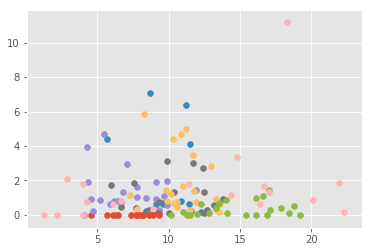

In [64]:
for i in range(0,len(catch_ratio)):
    plt.scatter(wind_speed[int(i+20)][:np.asarray(catch_ratio).shape[1]],catch_ratio[i])
plt.show()

In [61]:
(np.asarray()).shape

TypeError: asarray() missing 1 required positional argument: 'a'

In [ ]:
np.asarray().shape

In [ ]:
def plt_all_day_diff(day_diff_obs,day_range,initialisation_day, calendar_month, calendar_year, initialisation_hh):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    # Vertical line to see if too high or too little
    ax.axvline(0, color =spagh.vert_col, linewidth=3)

    # Horizontal line to show end of day
    ax.axhline(0,color = spagh.vert_col, linewidth = 3)
    ax.axhline(24,color = spagh.vert_col, linewidth = 3)
    ax.axhline(48,color = spagh.vert_col, linewidth = 3)


    for i in day_range:
        if i == 5:
            Xmax = 41
        elif i == 6:
            Xmax = 17
        else:
            Xmax = np.asarray(day_diff_obs).shape[1]
        plt.scatter(day_diff_obs[i][:Xmax],np.arange(0,np.asarray(day_diff_obs[i][:Xmax]).shape[0]),
                            color = colors[i],
                        alpha = 0.8, s = 200,
                      label='%s %s %s 0%s UTC' %(initialisation_day[i],
                                            calendar_month[i],calendar_year[i],initialisation_hh[i]) )


        ### fine tuning
    lgd = ax.legend(loc='center left',bbox_to_anchor=(1, .75),
             fancybox=True, shadow=True, #ncol=3, 
              fontsize=spagh.label_fs-4)
    lgd.get_title().set_fontsize(spagh.label_fs-4)
    plt.setp(lgd.get_texts(), color=spagh.blue)


    #lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.37),
     #         fancybox=True, shadow=True, ncol=3, fontsize=spagh.label_fs)
    frame = lgd.get_frame()
    frame.set_facecolor('white')

    # yaxis
    #a = lead_time_sfc[0][0:48]
    ax.set_ylim(-0.5,49-0.5)
    ax.set_ylabel('time [UTC]', fontsize=spagh.label_fs)
    ax.set_yticks(np.arange(0,49))

    xdays = [0, '', '', 3, '' , '',
            6,'','', 9,'','',12,'','',15,'','',18,'','',
             21, '','',
            24, '','',27, '','', 30, '','',
            33,'','', 36,'','',39,'','',42,'','',45,'','',
            48]
    ax.set_yticklabels(xdays, #rotation = 25, 
                       fontsize = spagh.tick_fs)

            # xaxis
    ax.set_xlim(-15,5)
    ax.set_xticks(np.arange(-15,10,5))
    ax.set_xticklabels(['', -10, '', 0, '', 10],fontsize = spagh.tick_fs)
    ax.set_title('Precipitation amount' , fontsize=spagh.fontsize)
    ax.set_xlabel('Difference [mm]', fontsize=spagh.fontsize)

    # tight layout
    plt.tight_layout()
    return(lgd)

In [ ]:
def plt_scatter_all_days(obs_var,obs_ret,x_obs, intercept_obs,gradient_obs,
                         day_range, in_day, cal_mon,
                              cal_year,in_hh):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    for i in day_range:

        plt.scatter(np.asarray(obs_var)[i,:-1],
                    np.asarray(obs_ret)[i,:],color=colors[i],
                   alpha = 0.8, s = 150,
                          label='%s %s %s 0%s UTC' %(in_day[i],
                                                cal_mon[i],cal_year[i],in_hh[i]) )
    ax.plot(x_obs, intercept_obs + gradient_obs*x_obs,  
                    color ='k',linewidth = 5.,
            alpha=0.8)#,
            #label='y = {:.2f} + {:.2f}x'.format(intercept_obs, gradient_obs))
    ax.text(0.03,0.95, 'y = {:.2f} + {:.2f}x'.format(intercept_obs, gradient_obs),
            verticalalignment ='top', horizontalalignment='left', color = 'k',
             transform = ax.transAxes, fontsize = spagh.label_fs-4,
             bbox={'facecolor':'white','alpha':.8,'pad':10})
    
    ### fine tuning
    lgd = ax.legend(loc='center left',bbox_to_anchor=(1, .75),
             fancybox=True, shadow=True, #ncol=3, 
              fontsize=spagh.label_fs-4)
    lgd.get_title().set_fontsize(spagh.label_fs-4)
    plt.setp(lgd.get_texts(), color=spagh.blue)


    frame = lgd.get_frame()
    frame.set_facecolor('white')


    ax.plot([0,50], [0,50], linestyle = '-', color=spagh.memb_col)
            # yaxis
    ax.set_ylim(-1,50)
    ax.set_yticks(np.arange(0,55,5))
    ax.set_yticklabels([0, '',10,'',20,'',30,'',40,'',50,'',60,'',70,'',80,'',90],fontsize = spagh.tick_fs)
            # xaxis
    ax.set_xlim(-1,50)
    ax.set_xticks(np.arange(0,55,5))
    ax.set_xticklabels([0, '',10,'',20,'',30,'',40,'',50,'',60,'',70,'',80,'',90],fontsize = spagh.tick_fs)
    ax.set_title('Precipitation amount [mm]', fontsize=spagh.fontsize)

    

    ax.set_ylabel('retrieval', fontsize=spagh.label_fs)
    ax.set_xlabel('double fence', fontsize=spagh.label_fs)


        # tight layout
    plt.tight_layout()
    return(lgd)

In [ ]:
day_range = np.arange(0,len(day_diff_obs)-1)
lgd = plt_all_day_diff(day_diff_obs,day_range,initialisation_day, calendar_month, calendar_year, initialisation_hh)
fig_name = 'diff_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()

In [ ]:
day_diff_obs2 = np.asarray(day_diff_obs)
day_diff_obs2[5,12:] = np.nan
day_diff_obs2[6,17:] = np.nan

In [ ]:
print('MAE: ', np.nanmean(np.abs(day_diff_obs2)))

In [ ]:
for i in range(len(obs_var)):
    print('snowfall obs (12h) [mm] 2%s Dec:' %i, np.asarray(obs_var)[i,12])
 #   print('snowfall obs (24h) [mm] 2%s Dec:' %i, np.asarray(obs_var)[i,24])
 #   print('snowfall obs (48h) [mm] 2%s Dec:' %i, np.asarray(obs_var)[i,47])

In [ ]:
for i in range(len(obs_ret)):
    print('snowfall ret (12h) [mm] 2%s Dec:' %i, np.asarray(obs_ret)[i,12])
#    print('snowfall ret (24h) [mm] 2%s Dec:' %i, np.asarray(obs_ret)[i,24])
 #   print('snowfall ret (48h) [mm] 2%s Dec:' %i, np.asarray(obs_ret)[i,47])

In [ ]:
ratio = np.empty(shape=(np.asarray(day_diff_obs2).shape))
for i in range(0,len(obs_var)):
    ratio[i][:] = np.asarray(day_diff_obs2)[i,12]/np.asarray(obs_var)[i,12]
    if np.isinf(ratio).any() == True:
        a = (np.isinf(np.asarray(day_diff_obs2)[i,12]/np.asarray(obs_var)[i,12]))
        ratio[i][a] = np.nan

all_ratio = []
for i in range(0,len(ratio)):
    k = (np.asarray(ratio)[i,:])*100
    print('perc Difference (12h) 2%s Dec:' %i, np.nanmean(np.asarray(ratio)[i,12])*100)
    all_ratio.append(k)
print('all day perc Difference (12h):', np.nanmean(all_ratio[:7]))
print('all day perc Difference 21-26 (12h):', np.nanmean(all_ratio[1:7]))
print('all day perc Difference 21-24 (12h):', np.nanmean(all_ratio[1:5]))

In [ ]:
ratio = np.empty(shape=(np.asarray(day_diff_obs2).shape))
for i in range(0,len(obs_var)):
    ratio[i][:] = np.asarray(day_diff_obs2)[i,24]/np.asarray(obs_var)[i,24]
    if np.isinf(ratio).any() == True:
        a = (np.isinf(np.asarray(day_diff_obs2)[i,24]/np.asarray(obs_var)[i,24]))
        ratio[i][a] = np.nan

all_ratio = []
for i in range(0,len(ratio)):
    k = (np.asarray(ratio)[i,:])*100
    print('perc Difference (24h) 2%s Dec:' %i, np.nanmean(np.asarray(ratio)[i,24])*100)
    all_ratio.append(k)
print('all day perc Difference (24h):', np.nanmean(all_ratio[:7]))
print('all day perc Difference 21-26 (48h):', np.nanmean(all_ratio[1:7]))

In [ ]:
ratio = np.empty(shape=(np.asarray(day_diff_obs2)[:,47].shape))
for i in range(0,len(obs_var)):
    ratio[i] = np.asarray(day_diff_obs2)[i,47]/np.asarray(obs_var)[i,47]
    if np.isinf(ratio).any() == True:
        a = (np.isinf(np.asarray(day_diff_obs2)[i,47]/np.asarray(obs_var)[i,47]))
        ratio[i][a] = np.nan

all_ratio = []
for i in range(0,len(ratio)):
    k = np.nanmean(np.asarray(ratio)[i])*100
    print('perc Difference (48h) 2%s Dec:' %i, np.nanmean(np.asarray(ratio)[i])*100)
    all_ratio.append(k)
print('all day perc Difference (48h):', np.nanmean(all_ratio[:7]))
print('all day perc Difference 21-26 (48h):', np.nanmean(all_ratio[1:7]))

In [ ]:
obs_ret = np.asarray(obs_ret)[:,::60]
obs_ret3 = np.asarray(obs_ret)
obs_ret3[5,12:] = np.nan
obs_ret3[6,17:] = np.nan

In [ ]:
for i in range(len(obs_ret3)):
    print('snowfall (24h) [mm] 2%s Dec:' %i, np.asarray(obs_ret3)[i,24])
    print('snowfall (48h) [mm] 2%s Dec:' %i, np.asarray(obs_ret3)[i,47])

In [ ]:
#obs_ret = np.asarray(obs_ret)[:,::60]
obs_ret2 = np.asarray(obs_ret)
obs_ret2[5,41:] = np.nan
obs_ret2[6,17:] = np.nan



In [ ]:
from scipy import stats
PP_obs_flat = np.ndarray.flatten(np.asarray(obs_var)[:,:-1])
PP_ret_flat = np.ndarray.flatten((obs_ret2)[:,:])

x_obs = np.asarray(PP_obs_flat)
y_obs = np.asarray(PP_ret_flat)
mask_obs = ~np.isnan(x_obs) & ~np.isnan(y_obs)
gradient_obs, intercept_obs, r_value, p_value, std_err = stats.linregress(x_obs[mask_obs],y_obs[mask_obs])

In [ ]:
lgd = plt_scatter_all_days(obs_var,obs_ret2,x_obs,intercept_obs,gradient_obs,
                           day_range, initialisation_day, calendar_month,
                              calendar_year,initialisation_hh)
fig_name = 'obs_ret_%s%s%s_%s_%s.png' %(calendar_year[0],month,initialisation_day[0],initialisation_day[len(obs_var)-2],hh)
if savefig == 1:
    plt.savefig('%s/%s' % (figdir_scatter, fig_name), format = form,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print('plot saved: %s/%s' %(figdir_scatter,fig_name))
elif savefig == 0:
    plt.show()
plt.close()